# Imports

In [54]:
import numpy as np
import pandas as pd
import xml
import xml.etree.ElementTree as ET

# Parsing Util

In [55]:
def parse(element: xml.etree.ElementTree.Element):
    """
    Parses an xml element into a dictionary.
    """
    d = {}
    if not element.text or '\t' in element.text:
        for child in element:
            if child.tag in d:
                if type(d[child.tag]) is list:
                    d[child.tag].append(parse(child))
                else:
                    d[child.tag] = [d[child.tag], parse(child)]
            else:
                d[child.tag] = parse(child)
    else:
        return element.text
    
    return d

    

In [56]:
import os
names = list(set([name.split('.')[0] for name in os.listdir('data')]))

In [57]:
import random
import cv2

def sample_data(ids: list[tuple[str, dict, np.ndarray]]):
    """
    Parses the xml files and loads the images for the given ids
    """
    sample = []
    for id in ids:
        tree = xml.etree.ElementTree.parse(f'data/{id}.xml')
        root = tree.getroot()
        annotation = parse(root)
        image = cv2.imread(f'data/{id}.jpg')
        sample.append((id, image, annotation))
    
    return sample

# Visualization

In [37]:
from matplotlib import pyplot as plt
from matplotlib import patches

def visualize_sample(sample):
    """
    Plot the images with the bounding boxes for the given sample
    """
    num_samples = len(sample)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, (id, image, annotation) in enumerate(sample):
        print(annotation)
        ax = axes[i]
        ax.imshow(image)
        if "object" in annotation:
            if type(annotation["object"]) is not list:
                annotation["object"] = [annotation["object"]]
            for obj in annotation["object"]:
                x = int(obj["bndbox"]["xmin"])
                y = int(obj["bndbox"]["ymin"])
                w = int(obj["bndbox"]["xmax"]) - x
                h = int(obj["bndbox"]["ymax"]) - y
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                # label the box
                ax.text(x, y, obj["name"], color='r')
                ax.add_patch(rect)
        ax.set_title(id)
        ax.axis("off")


In [58]:
def visualize_random_sample(names: list[str], num_samples: int):
    """
    Visualizes a random sample of the given data
    """
    ids = random.sample(names, num_samples)
    sample = sample_data(ids)
    visualize_sample(sample)

{'folder': 'combinate', 'filename': 'lower_501660.jpg', 'path': '/home/vboxuser/Desktop/dataset_mf_1001/combinate/lower_501660.png', 'source': {'database': 'Unknown'}, 'size': {'width': '320', 'height': '240', 'depth': '3'}, 'segmented': '0', 'object': {'name': 'ball', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '41', 'ymin': '48', 'xmax': '94', 'ymax': '100'}}}
{'folder': {}, 'filename': 'upper_656507.jpg', 'path': 'upper_656507_jpg.rf.0b825552ed0a8d4d1606468cac806577.jpg', 'source': {'database': 'roboflow.ai'}, 'size': {'width': '640', 'height': '480', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'goalspot', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'occluded': '0', 'bndbox': {'xmin': '1', 'xmax': '16', 'ymin': '268', 'ymax': '298'}}, {'name': 'ball', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'occluded': '0', 'bndbox': {'xmin': '58', 'xmax': '83', 'ymin': '114', 'ymax': '139'}}, {'name': 'ball', 'pose': 'Unsp

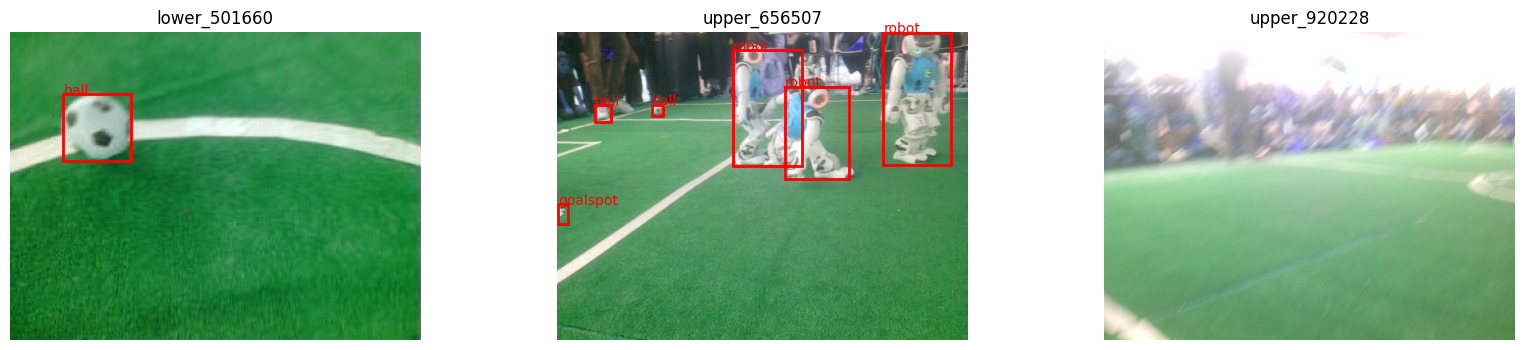

In [61]:
visualize_random_sample(names, 3)